In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, boxcox
from kneed import KneeLocator

In [2]:
import pandas as pd

# Load and filter medications data
medications_file_path = 'medications.csv'
df_medications = pd.read_csv(medications_file_path, encoding='latin1')

# Filter RXDRSC1 prefixes
prefixes = ('E11', 'E78', 'I10', 'E11.', 'E78.', 'I10.')
df_medications_filtered = df_medications[['SEQN', 'RXDRSC1']].copy()
df_medications_filtered = df_medications_filtered[
    df_medications_filtered['RXDRSC1'].str.startswith(prefixes, na=False)
]

# Group and limit entries
df_medications_filtered = (
    df_medications_filtered.groupby('SEQN')['RXDRSC1']
    .apply(lambda x: list(x[:1]))  # Ensure grouped entries are lists
    .reset_index()
)

# Explode the list into single values
df_medications_filtered = df_medications_filtered.explode('RXDRSC1', ignore_index=True)

# Finalize medication data
df_medications_final = df_medications_filtered.reset_index(drop=True)

# Load and filter demographic data
df_demographic = pd.read_csv('demographic.csv')
columns_to_keep_demographic = [
    'SEQN', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'INDFMPIR', 
    'INDHHIN2', 'DMDEDUC2', 'DMDHHSIZ', 'RIDEXPRG', 
    'WTINT2YR', 'WTMEC2YR', 'DMDHHSZE', 'DMQMILIZ'
]
df_demographic_filtered = df_demographic[columns_to_keep_demographic].copy()

# Modify RIDEXPRG column
df_demographic_filtered.loc[df_demographic_filtered['RIAGENDR'] == 1, 'RIDEXPRG'] = 0
df_demographic_filtered.loc[
    (df_demographic_filtered['RIAGENDR'] == 2) & (df_demographic_filtered['RIDEXPRG'].isna()), 'RIDEXPRG'
] = 3

# Replace missing values with mean
columns_to_check = ['INDFMPIR', 'INDHHIN2', 'DMDEDUC2', 'WTMEC2YR']
for col in columns_to_check:
    df_demographic_filtered[col] = df_demographic_filtered[col].fillna(df_demographic_filtered[col].mean())

# One-hot encode categorical features
categorical_features = ['RIDRETH1', 'RIDEXPRG']
df_encoded_demographic = pd.get_dummies(df_demographic_filtered, columns=categorical_features, drop_first=True)

# Convert to integer after handling all NaNs
df_encoded_demographic = df_encoded_demographic.fillna(0).astype(int)

# Load and filter examination data
df_examination = pd.read_csv('examination.csv')
columns_to_keep_examination = [
    'SEQN', 'BPXSY1', 'BPXDI1', 'BPXSY2', 'BPXDI2', 'BPXSY3', 'BPXDI3', 
    'BMXWT', 'BMXHT', 'BMXBMI', 'BMXSAD1', 'BMXSAD2'
]
df_examination_filtered = df_examination[columns_to_keep_examination].copy()

# Replace NaN with mean in examination data
for col in columns_to_keep_examination[1:]:
    df_examination_filtered[col] = df_examination_filtered[col].fillna(df_examination_filtered[col].mean())

# Load and filter questionnaire data
df_questionnaire = pd.read_csv('questionnaire.csv')
columns_to_keep_questionnaire = [
    'SEQN', 'ALQ101', 'BPQ040A', 'CBQ505', 'CBQ550', 'MCQ010', 
    'MCQ160C', 'PFQ054', 'PFQ057', 'PAD680'
]
df_questionnaire_filtered = df_questionnaire[columns_to_keep_questionnaire].copy()

# One-hot encode categorical features in questionnaire data
categorical_features_questionnaire = ['ALQ101', 'BPQ040A', 'CBQ505', 'CBQ550', 'MCQ010', 'MCQ160C', 'PFQ054', 'PFQ057']
df_questionnaire_encoded = pd.get_dummies(df_questionnaire_filtered, columns=categorical_features_questionnaire, drop_first=True)

# Replace NaN with mean in questionnaire data
for col in df_questionnaire_encoded.select_dtypes(include=['float64', 'int64']).columns:
    df_questionnaire_encoded[col] = df_questionnaire_encoded[col].fillna(df_questionnaire_encoded[col].mean())

# Convert to integer after handling all NaNs
df_questionnaire_encoded = df_questionnaire_encoded.astype(int)

# Continue for diet and lab datasets...
df_diet = pd.read_csv('diet.csv')
columns_to_keep_diet = [
    'SEQN', 'DR1TNUMF', 'DR1TCARB', 'DR1TSFAT', 'DR1TCHOL', 'DR1TVB6', 'DR1TSUGR',
    'DR1TFIBE', 'DR1TCALC', 'DR1TPHOS', 'DR1TMAGN', 'DR1TIRON', 'DR1TZINC',
    'DR1TCOPP', 'DR1TSODI', 'DR1TPOTA', 'DR1TSELE', 'DR1TCAFF', 'DR1TPROT'
]
df_diet_filtered = df_diet[columns_to_keep_diet].copy()
for col in columns_to_keep_diet[1:]:
    df_diet_filtered[col] = df_diet_filtered[col].fillna(df_diet_filtered[col].mean())

df_labs = pd.read_csv('labs.csv')
columns_to_keep_labs = [
    'SEQN', 'LBXWBCSI', 'LBDHDD', 'LBXIN', 'LBXTC', 'LBXBPB', 'LBDBPBSI', 'LBXBCD', 'LBXBSE'
]
df_labs_filtered = df_labs[columns_to_keep_labs].copy()
for col in columns_to_keep_labs[1:]:
    df_labs_filtered[col] = df_labs_filtered[col].fillna(df_labs_filtered[col].mean())

# Merge all datasets
df_merged = pd.merge(df_encoded_demographic, df_medications_final, on='SEQN', how='inner')
df_merged = pd.merge(df_merged, df_examination_filtered, on='SEQN', how='inner')
df_merged = pd.merge(df_merged, df_questionnaire_encoded, on='SEQN', how='inner')
df_merged = pd.merge(df_merged, df_diet_filtered, on='SEQN', how='inner')
df_merged = pd.merge(df_merged, df_labs_filtered, on='SEQN', how='inner')

# Display the merged dataset
print(df_merged.head())
print(df_merged.shape[0])

    SEQN  RIAGENDR  RIDAGEYR  INDFMPIR  INDHHIN2  DMDEDUC2  DMDHHSIZ  \
0  73557         1        69         0         4         3         3   
1  73558         1        54         1         7         3         4   
2  73559         1        72         4        10         4         2   
3  73561         2        73         5        15         5         2   
4  73562         1        56         4         9         4         1   

   WTINT2YR  WTMEC2YR  DMDHHSZE  ...  DR1TCAFF  DR1TPROT  LBXWBCSI  LBDHDD  \
0     13281     13481         2  ...     203.0     43.63       4.7    65.0   
1     23682     24471         0  ...     240.0    338.13      12.6    50.0   
2     57214     57193         2  ...      45.0     64.61       7.2    60.0   
3     63709     65541         2  ...      24.0     55.24       6.6    85.0   
4     24978     25344         0  ...     144.0     55.11       9.4    38.0   

       LBXIN  LBXTC    LBXBPB  LBDBPBSI    LBXBCD      LBXBSE  
0  13.526809  167.0  1.105511   0.

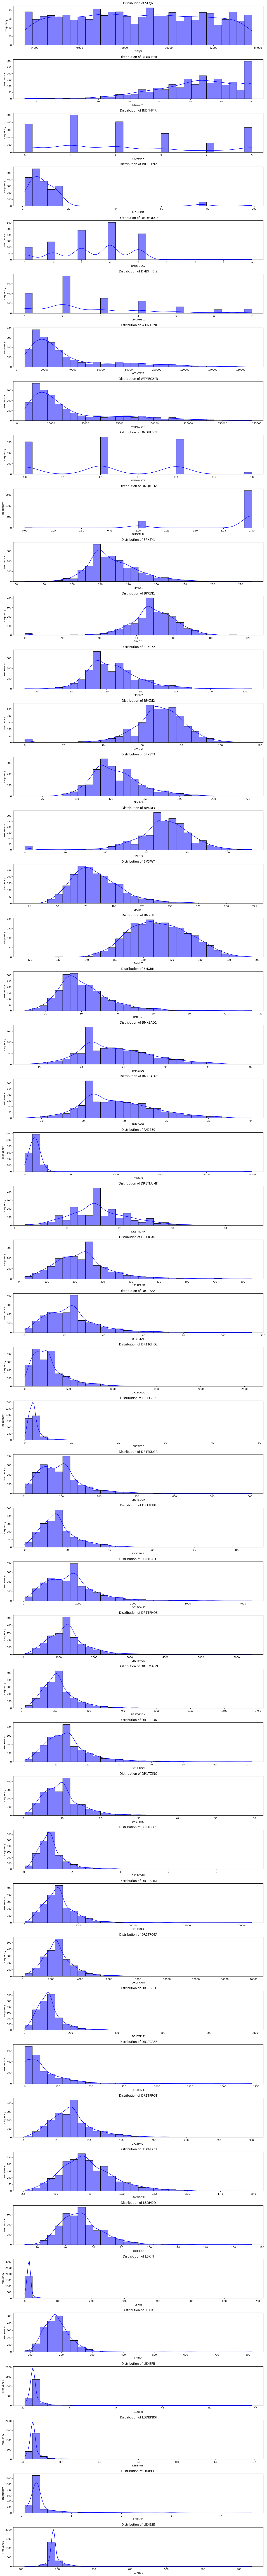

In [3]:
# Filter numeric columns excluding those with 1 or 2 unique values
numeric_columns = [
    col for col in df_merged.select_dtypes(include=['number']).columns
    if df_merged[col].nunique() > 2
]

# Plot distribution plots for numeric features with more than 2 unique values
plt.figure(figsize=(15, len(numeric_columns) * 3))
for idx, column in enumerate(numeric_columns, 1):
    plt.subplot(len(numeric_columns), 1, idx)
    sns.histplot(df_merged[column], kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.tight_layout()

# Save distribution plots
distribution_plots_path = 'distribution_plots.png'
plt.savefig(distribution_plots_path)
plt.show()

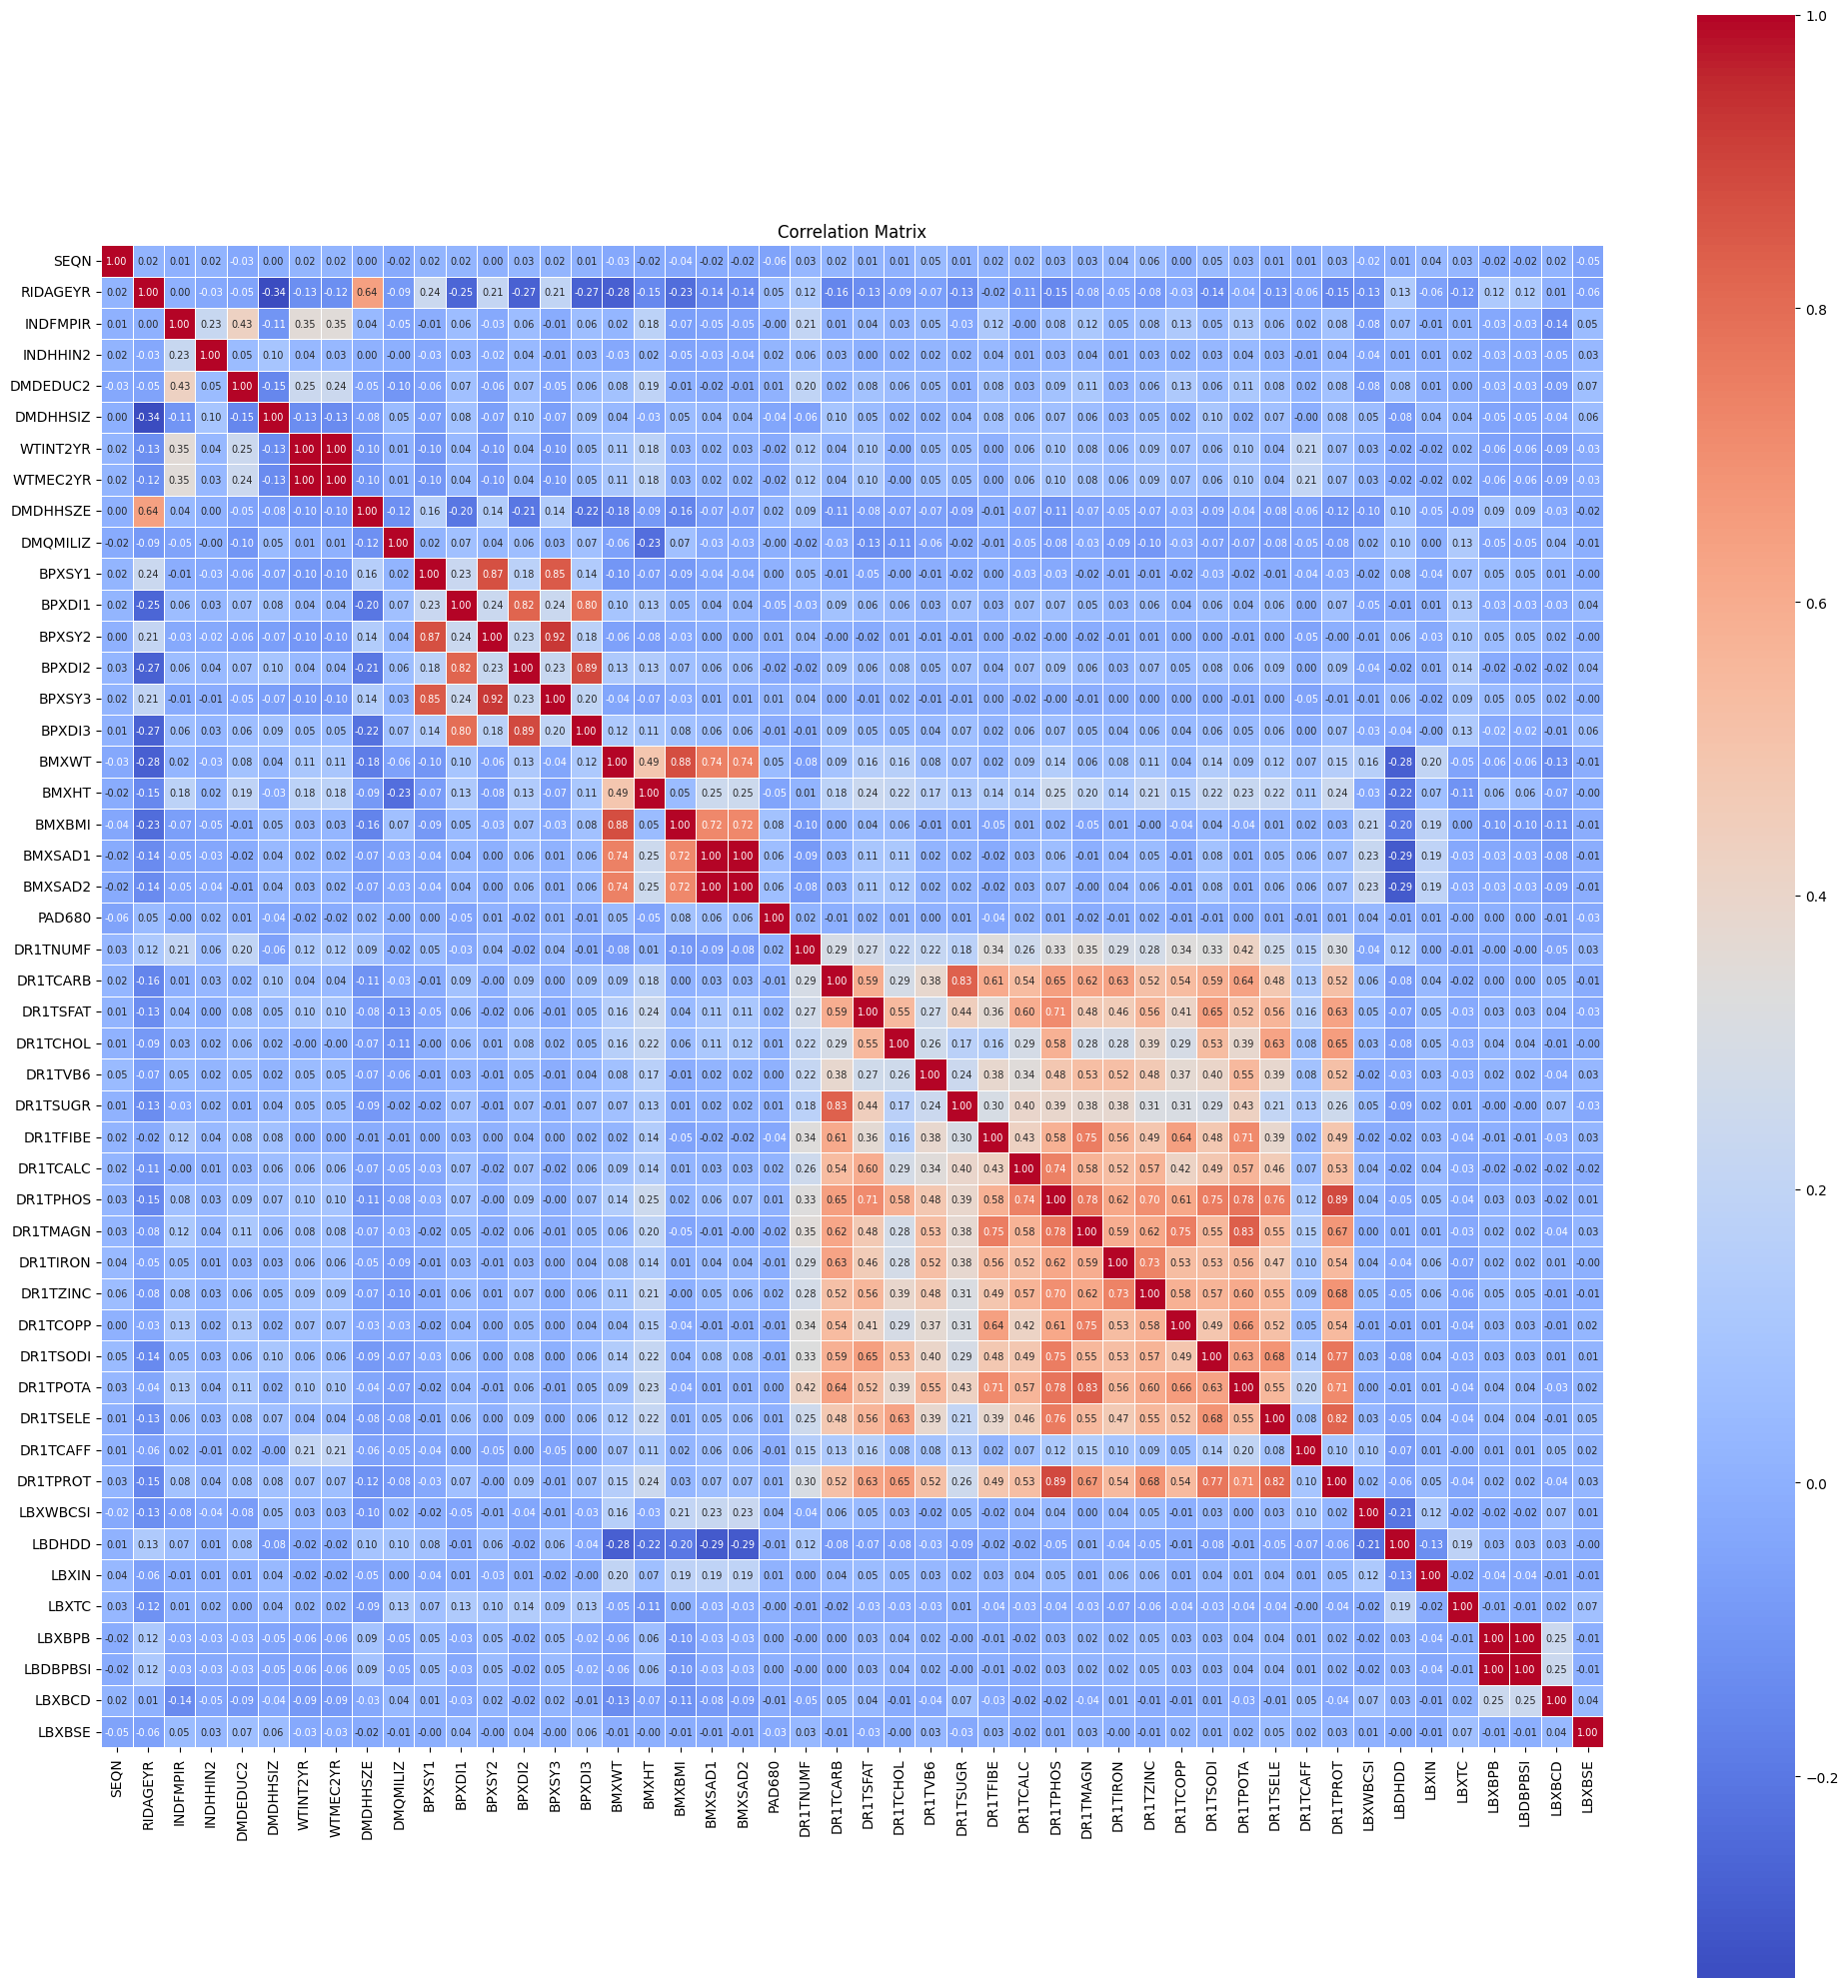

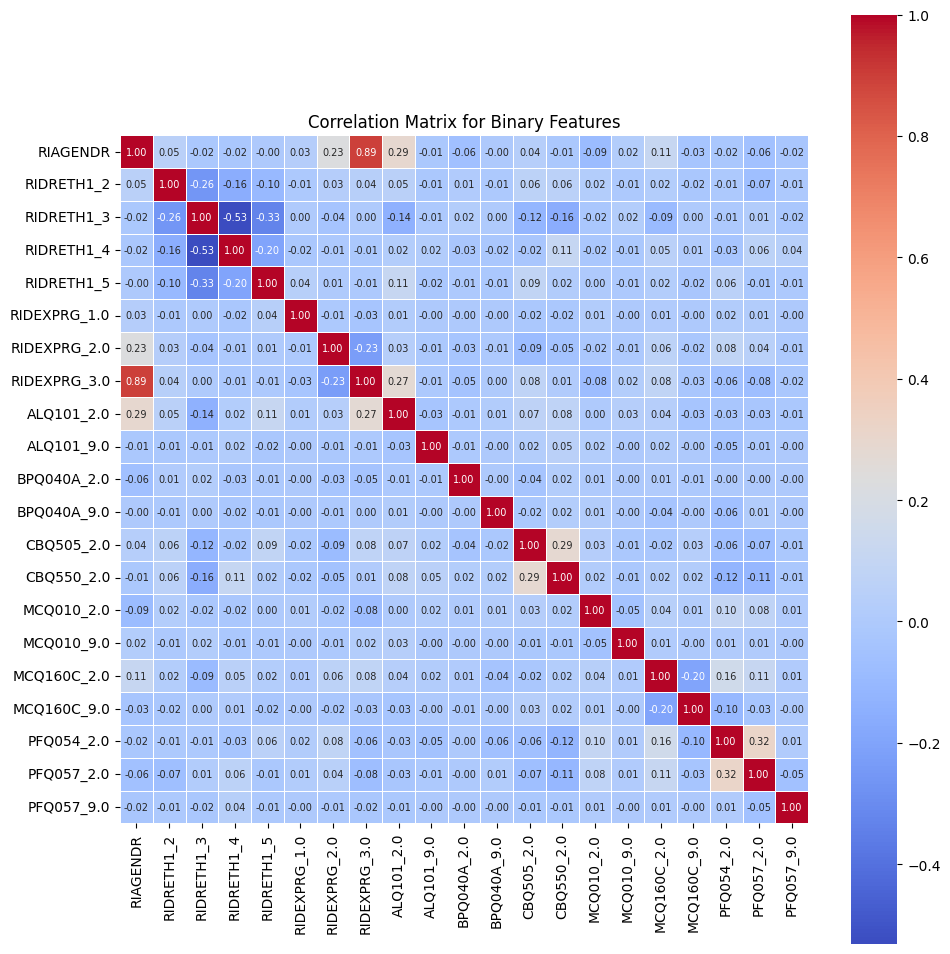

In [4]:
# Compute correlation matrix for filtered numeric columns
numeric_df = df_merged[numeric_columns]
correlation_matrix = numeric_df.corr()

# Plot correlation matrix
plt.figure(figsize=(20, 20))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    square=True,
    linewidths=0.5,
    annot_kws={"size": 7}
)
plt.title("Correlation Matrix")
plt.tight_layout()

# Save correlation matrix plot
correlation_plot_path = 'correlation_matrix_plot.png'
plt.savefig(correlation_plot_path)
plt.show()


# Filter binary numeric columns (features with exactly 2 unique values)
binary_columns = [
    col for col in df_merged.select_dtypes(include=['number']).columns
    if df_merged[col].nunique() == 2
]

# Ensure we have binary columns to process
if binary_columns:
    # Compute correlation matrix for binary features
    binary_df = df_merged[binary_columns]
    binary_correlation_matrix = binary_df.corr()

    # Plot correlation matrix
    plt.figure(figsize=(10, 10))
    sns.heatmap(
        binary_correlation_matrix,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        cbar=True,
        square=True,
        linewidths=0.5,
        annot_kws={"size": 7}
    )
    plt.title("Correlation Matrix for Binary Features")
    plt.tight_layout()

    # Save correlation matrix plot
    binary_correlation_plot_path = 'binary_correlation_matrix_plot.png'
    plt.savefig(binary_correlation_plot_path)
    plt.show()
else:
    print("No binary features found for correlation analysis.")


In [5]:
# Drop columns only if they exist in the DataFrame
columns_to_drop = ['WTINT2YR', 'RIDEXPRG_3.0', 'BPXSY2', 'BPXSY3', 'BPXDI2', 'BPXDI3', 
                   'BMXBMI', 'BMXSAD1', 'BMXSAD2', 'DR1TSUGR', 'DR1TPROT', 'LBDBPBSI']

df_merged.drop(columns=[col for col in columns_to_drop if col in df_merged.columns], inplace=True)

# Exclude one-hot encoded and identifier columns
one_hot_columns = [col for col in df_merged.columns if df_merged[col].nunique() == 2 and df_merged[col].max() <= 1]
excluded_columns = one_hot_columns + ['SEQN']

# Detect numerical columns
numerical_columns = [col for col in df_merged.select_dtypes(include=['float64', 'int64']).columns if col not in excluded_columns]

# Standardize numerical columns
scaler = StandardScaler()
df_merged[numerical_columns] = scaler.fit_transform(df_merged[numerical_columns])

# Transform skewed features
def apply_boxcox(df, columns, threshold=2.0):
    transformed_features = []
    for col in columns:
        if skew(df[col]) > threshold:
            df[col], _ = boxcox(df[col].clip(lower=1))
            transformed_features.append(col)
    return transformed_features

transformed_features = apply_boxcox(df_merged, numerical_columns)
print(f"Box-Cox transformed features: {transformed_features}")

# Remove outliers using IQR
#def remove_outliers_iqr(df, columns, threshold=3):
#     for col in columns:
#         Q1 = df[col].quantile(0.25)
#         Q3 = df[col].quantile(0.75)
#         IQR = Q3 - Q1
#         lower_bound = Q1 - threshold * IQR
#         upper_bound = Q3 + threshold * IQR
#         df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
#     return df

#df_merged = remove_outliers_iqr(df_merged, numerical_columns)
print(df_merged.shape[0])


Box-Cox transformed features: ['INDHHIN2', 'PAD680', 'DR1TCHOL', 'DR1TVB6', 'DR1TFIBE', 'DR1TMAGN', 'DR1TZINC', 'DR1TCOPP', 'DR1TSODI', 'DR1TSELE', 'DR1TCAFF', 'LBXIN', 'LBXTC', 'LBXBPB', 'LBXBCD', 'LBXBSE']
2000


In [9]:
# Combine numerical and one-hot encoded columns for PCA
columns_for_pca = numerical_columns + one_hot_columns

# Standardize all columns for PCA
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_merged[columns_for_pca])

# Apply PCA
pca = PCA(n_components=0.95)
pca_data = pca.fit_transform(df_scaled)
pca_components = pd.DataFrame(pca.components_, columns=columns_for_pca)

print(pca_components.head())

# Extract top features from PCA
def consolidate_top_features(pca_components, top_n=3, num_components=5):
    top_features = set()
    for i in range(num_components):
        component = pca_components.iloc[i]
        top_features.update(component.abs().nlargest(top_n).index.tolist())
    return list(top_features)

top_features = consolidate_top_features(pca_components)
print(f"Top features from PCA: {top_features}")


   RIAGENDR  RIDAGEYR  INDFMPIR  INDHHIN2  DMDEDUC2  DMDHHSIZ  WTMEC2YR  \
0 -0.135916 -0.070881  0.056854 -0.007032  0.062098  0.029859  0.058046   
1 -0.146274 -0.062167  0.286215 -0.068001  0.284807 -0.147593  0.404661   
2  0.019299  0.502371  0.113862 -0.018887  0.058213 -0.248160  0.058135   
3  0.409166 -0.149855  0.169219 -0.014594  0.143279  0.032101  0.160758   
4 -0.186206  0.040484  0.242027  0.021774  0.190452 -0.018666 -0.168022   

   DMDHHSZE  DMQMILIZ    BPXSY1  ...  BPQ040A_9.0  CBQ505_2.0  CBQ550_2.0  \
0 -0.051349 -0.051993 -0.020187  ...     0.017449   -0.055119   -0.037766   
1 -0.056168 -0.129761 -0.092480  ...    -0.014886   -0.208040   -0.244017   
2  0.401625 -0.087636  0.136259  ...     0.014858    0.128920   -0.031440   
3 -0.146313  0.323079 -0.032436  ...    -0.020266   -0.055920   -0.148779   
4  0.055296 -0.039363  0.152172  ...    -0.026640    0.001068   -0.067659   

   MCQ010_2.0  MCQ010_9.0  MCQ160C_2.0  MCQ160C_9.0  PFQ054_2.0  PFQ057_2.0  \
0    0.

Optimal number of clusters: 4


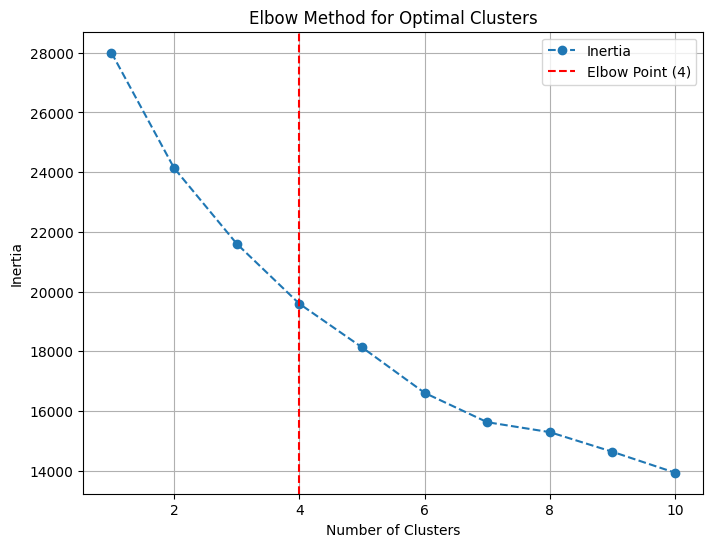

In [10]:
# Standardize the selected features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_merged[top_features])

# Calculate inertia for different numbers of clusters
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

# Determine the optimal number of clusters using the elbow method
elbow_point = KneeLocator(range(1, 11), inertia, curve="convex", direction="decreasing").knee
print(f"Optimal number of clusters: {elbow_point}")

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--', label='Inertia')
plt.axvline(x=elbow_point, color='red', linestyle='--', label=f'Elbow Point ({elbow_point})')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.legend()
plt.grid()
plt.show()


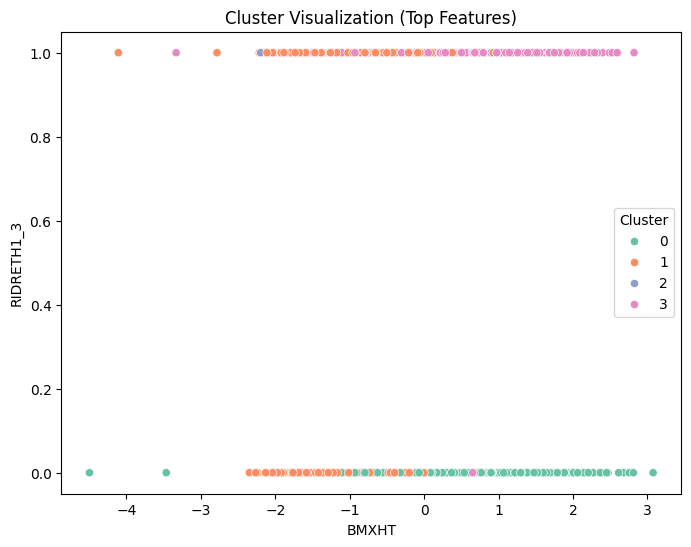

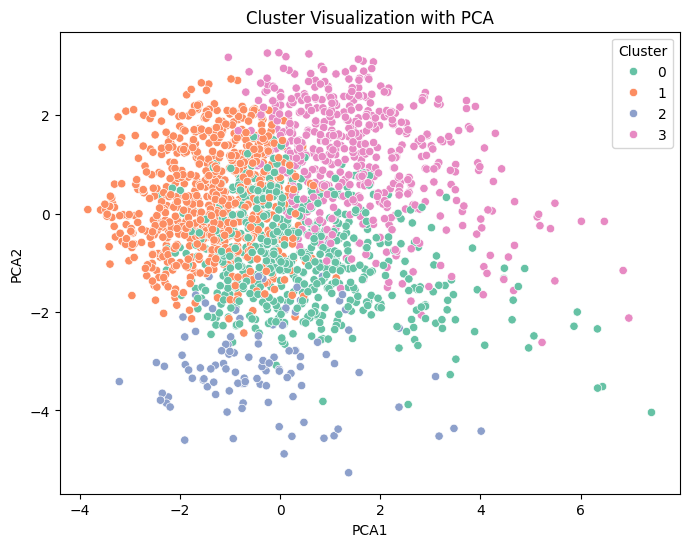

Cluster Profile (Top Features):
            BMXHT  RIDRETH1_3  DR1TPOTA  DMQMILIZ  RIDRETH1_4  WTMEC2YR  \
Cluster                                                                   
0        0.429423    0.000000  0.250993 -0.109047    0.589404 -0.625412   
1       -0.784151    0.490119 -0.469843  0.376852    0.138340 -0.192489   
2       -0.365277    0.387387 -0.181166  0.398192    0.225225  0.090600   
3        0.715485    0.990494  0.427985 -0.502596    0.000000  0.976790   

         RIAGENDR  DR1TPHOS  RIDEXPRG_2.0  INDFMPIR  RIDAGEYR  DR1TCARB  \
Cluster                                                                   
0       -0.588189  0.267432           0.0 -0.047628 -0.169785  0.306031   
1        0.816257 -0.501429           0.0 -0.222852  0.376959 -0.462280   
2        0.935101 -0.028105           1.0 -0.223988 -1.770964  0.103060   
3       -0.699751  0.422387           0.0  0.423525  0.024745  0.293893   

         DMDHHSZE  LBXWBCSI  
Cluster                      
0     

In [11]:
# Ensure `data_scaled` includes only top_features and is properly scaled
data_top_features = df_merged[top_features].copy()
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_top_features)

# Perform K-Means clustering
kmeans = KMeans(n_clusters=elbow_point, random_state=42)
df_merged['Cluster'] = kmeans.fit_predict(data_scaled)

# Visualize clusters using the first two top features
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_merged, x=top_features[0], y=top_features[1], hue='Cluster', palette='Set2')
plt.title("Cluster Visualization (Top Features)")
plt.xlabel(top_features[0])
plt.ylabel(top_features[1])
plt.show()

# PCA for Dimensionality Reduction
pca = PCA(n_components=2)
pca_data = pca.fit_transform(data_scaled)

# Add PCA components to df_merged for PCA-based visualization
df_merged['PCA1'] = pca_data[:, 0]
df_merged['PCA2'] = pca_data[:, 1]

# Visualize clusters using PCA components
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_merged, x='PCA1', y='PCA2', hue='Cluster', palette='Set2')
plt.title("Cluster Visualization with PCA")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()

# Generate Cluster Profile
cluster_profile = df_merged.groupby('Cluster')[top_features].mean()
print("Cluster Profile (Top Features):")
print(cluster_profile)
